# Modèles pour la data : données manquantes
## Author: Thierry KHAMPHOUSONE, Classe TC-44, IA-1
### 15/03/2021

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import mkl, multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import timeit

## 1) Chargement et analyse préliminaire des données

### a) Après avoir pris connaissance du dataset (auto-mpg-dataset.txt) et de sa description (auto- mpg-description.txt), indiquez pour chaque colonne si la variable est qualitative ou quantitative.

1. mpg (miles per gallon) \[**Variable quantitative**\]
2. cylinders \[**Variable qualitative ordinale**\]
3. displacement \[**Variable quantitative**\]
4. horsepower \[**Variable quantitative**\]
5. weight \[**Variable quantitative**\]
6. acceleration \[**Variable quantitative**\]
7. model year \[**Variable qualitative nominale**\]
8. origin (1. america, 2: europe, 3: asia) \[**Variable qualitative nominale**\]
9. car name \[**Variable qualitative nominale**\]

### b) Charger les données à partir du fichier texte contenant le dataset. L’objectif est de parvenir à un objet pandas.DataFrame.

In [354]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'car name']
df = pd.read_csv('../Dataset/auto-mpg-dataset.txt', names=column_names, delim_whitespace=True)

# convert into qualitative data
df['cylinders'] = df['cylinders'].astype(str);
df['model year'] = df['model year'].astype(str);
df['origin'] = df['origin'].astype(str);
df['car name'] = df['car name'].astype(str);


In [305]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [306]:
np.shape(df)

(406, 9)

In [307]:
type(df)

pandas.core.frame.DataFrame

In [308]:
df.dtypes

mpg             float64
cylinders        object
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year       object
origin           object
car name         object
dtype: object

J'ai bien chargé les données à partir du fichier texte contenant le dataset au sein d'un objet Pandas.DataFrame: la taille de l'échantillon est 406 et le nombres de features est 9.

Les types de données (qualitative/quantitative) ont été correctement modifiées

### c) Déterminer pour chaque colonne, à l’aide d’une fonction, le nombre de valeurs manquantes et leur taux (# valeurs manquantes/# valeurs total).

In [391]:
def get_number_missing_data(df):
    '''
    retourne le dataframe du nombre de données manquantes pour chaque colonne
    '''
    return df.isnull().sum()

In [438]:
def get_ratio_missing_data(df):
    '''
    retourne le dataframe de ratio de nombre de données manquantes pour chaque colonne
    '''
    miss_df = df.isnull().sum()
    return np.round(miss_df/int(np.shape(df)[0]), 3)

Nous avons ici 8 données manquantes pour la feature 'mpg' et 6 données manquantes pour la feature 'horsepower'

### d) Représenter graphiquement les données à l’aide de plusieurs nuages de points en deux di- mensions.

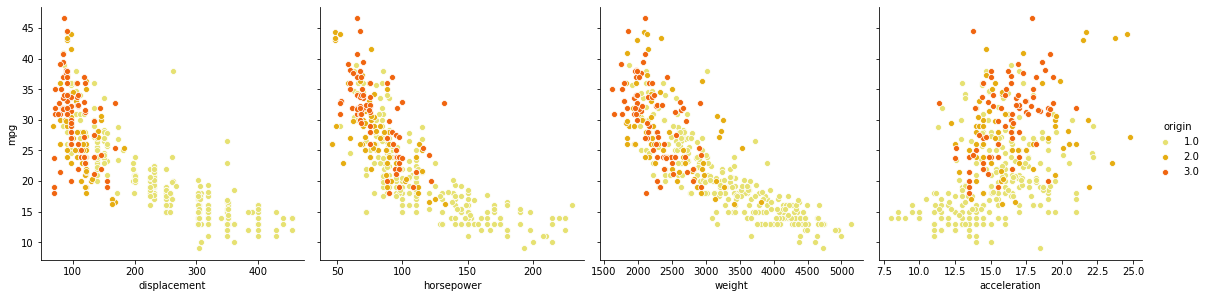

In [312]:
sns.pairplot(
    df, 
    x_vars=['displacement', 'horsepower', 'weight', 'acceleration'],
    y_vars=['mpg'],
    hue='origin',
    palette=sns.color_palette("CMRmap_r"),
    markers='o',
    height=4,
    dropna=False
);


## 2) Transformation du dataset : variation du taux de données manquantes

Vous avez sans doute remarqué que le nombre de données manquantes dans ce dataset est rela-
tivement faible.

Afin de pouvoir mettre en œuvre les méthodes présentées en cours et dans la suite de cette activi- té et de pouvoir étudier leur efficacité, nous nous proposons de venir augmenter artificiellement cette proportion, à un taux arbitraire en venant supprimer des données présentes.

1. une première qui supprimera aléatoirement des données dans une colonne donnée, de façon à ce que le taux de valeurs manquantes pour cette variable devienne égal à une valeur fixée arbitrairement par l’utilisateur

In [526]:
def delete_random_data(df, column, ratio):
    '''
    retourne un nouveau dataframe avec les données supprimées pour la colonne souhaité au ratio voulue
    une copie profonde est effectuée afin de ne pas perdre le dataframe initial
    '''
    miss_df = df.isnull().sum()
    size = np.shape(df)[0]

    # nombre de données manquantes hors déjà manquantes
    nb_data2delete = np.round(ratio*size - miss_df, 1).astype(int)[column] 
    # indice des données déjà manquantes
    already_nan = list(df[df.iloc[:, column].isna()].index.values)


    temp = np.arange(size) # index from 0 to nb of row of the dataframe
    temp2 = np.delete(temp, already_nan) # delete index where data is already nan
    np.random.shuffle(temp2) # shuffle to make a random
    index2delete = temp2[:nb_data2delete] # get random indexes to delete
    new_df = df.copy() # deep copy 

    for value in index2delete:
        new_df.iloc[value, column] = np.nan # delete value
    return new_df


In [545]:
# exemple d'utilisation 
# on supprime des données de la colonne weight de façon a perdre 40% des données
new_df = delete_random_data(df, 0, 0.40)

# on a bien un ratio de 0.40 de données manquantes
print('Ratio du nombre de données manquantes pour chaque colonne')
print(get_ratio_missing_data(new_df), '\n')

# on a supprimé au total 162 données.
print('Nombre de données manquantes pour chaque colonne')
print(get_number_missing_data(new_df))



Ratio du nombre de données manquantes pour chaque colonne
mpg             0.399
cylinders       0.000
displacement    0.000
horsepower      0.015
weight          0.000
acceleration    0.000
model year      0.000
origin          0.000
car name        0.000
dtype: float64 

Nombre de données manquantes pour chaque colonne
mpg             162
cylinders         0
displacement      0
horsepower        6
weight            0
acceleration      0
model year        0
origin            0
car name          0
dtype: int64


In [546]:
def delete_data_column_at_ratio(df, column_index):
    pass

2. une seconde qui supprimera aléatoirement des données dans l’ensemble du da- taframe (n’importe quelle colonne peut donc être concernée) de façon à ce que le taux de valeurs manquantes, au total, devienne égal à une valeur fixée arbitrairement par l’utilisateur.